In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
#gerekli kütüphaneleri import ettim

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.metrics import r2_score
import statsmodels.api as sm

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

from sklearn import metrics

from sklearn.model_selection import KFold, train_test_split, cross_val_predict, cross_val_score

from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing

In [2]:
# sınıflandırıcıları import ettim
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.neural_network import MLPClassifier


In [3]:
# csv dosyasını okuyorum
df = pd.read_csv('7allV03.csv', delimiter=';')
df.head()

,"category,text"
0,"siyaset , 3 milyon ile ön seçim vaadi mhp nin ..."
1,"siyaset , mesut_yılmaz yüce_divan da ceza alab..."
2,"siyaset , disko lar kaldırılıyor başbakan_yard..."
3,"siyaset , sarıgül anayasa_mahkemesi ne gidiyor..."
4,"siyaset , erdoğan idamın bir haklılık sebebi v..."


# **PySpark-ile-cok-Sinifli-Metin-Siniflandirma**


In [4]:
pip install findspark

In [5]:
pip install pyspark findspark

Note: you may need to restart the kernel to use updated packages.


In [6]:
import findspark
findspark.init('')
from pyspark.sql import SparkSession
spark = SparkSession.builder \
.master("local[4]") \
.appName("multiclass") \
.config("spark.executor.memory","4g") \
.config("spark.driver.memory","2g") \
.getOrCreate()


In [9]:
data = spark.read.option("header","True").option("inferSchema","True").option("sep",",").csv("7allV03.csv")
data

DataFrame[category: string, text: string]

In [10]:
from pyspark.sql.functions import col

# by top 20 categories
data.groupBy("Category").count().orderBy(col("count").desc()).show()

+----------+-----+
|  Category|count|
+----------+-----+
|  siyaset |  700|
|  ekonomi |  700|
|    dunya |  700|
|   kultur |  700|
|   saglik |  700|
|     spor |  700|
|teknoloji |  700|
+----------+-----+



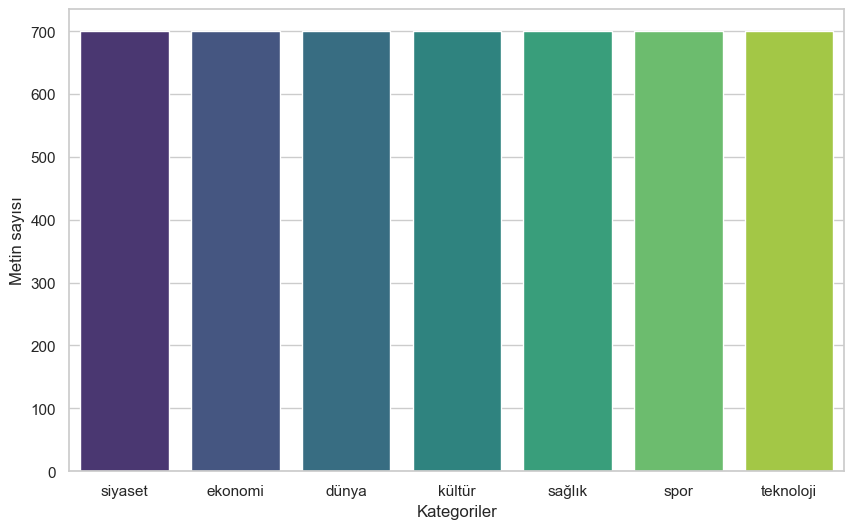

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Kategoriler ve değerler
categories = ['siyaset', 'ekonomi', 'dünya', 'kültür', 'sağlık', 'spor', 'teknoloji']
values = [700, 700, 700, 700, 700, 700, 700]

# Seaborn tema ayarı
sns.set(style="whitegrid")

# Görselleştirme
plt.figure(figsize=(10, 6))  # Grafiğin boyutunu ayarla
sns.barplot(x=categories, y=values, palette="viridis")  # Seaborn'un barplot fonksiyonunu kullanarak grafiği oluştur
plt.title('')
plt.xlabel('Kategoriler')
plt.ylabel('Metin sayısı')
plt.show()

In [12]:
data.columns

['category', 'text']

In [13]:
data.show(5)

+--------+--------------------+
|category|                text|
+--------+--------------------+
|siyaset | 3 milyon ile ön ...|
|siyaset | mesut_yılmaz yüc...|
|siyaset | disko lar kaldır...|
|siyaset | sarıgül anayasa_...|
|siyaset | erdoğan idamın b...|
+--------+--------------------+
only showing top 5 rows



In [14]:
# Spark DataFrame'ini Pandas DataFrame'e dönüştürün
pandas_df = data.toPandas()

# Pandas DataFrame'ini görüntüle
pandas_df.head()

,category,text
0,siyaset,3 milyon ile ön seçim vaadi mhp nin 10 olağan...
1,siyaset,mesut_yılmaz yüce_divan da ceza alabilirdi pr...
2,siyaset,disko lar kaldırılıyor başbakan_yardımcısı ar...
3,siyaset,sarıgül anayasa_mahkemesi ne gidiyor mustafa_...
4,siyaset,erdoğan idamın bir haklılık sebebi var demek ...


In [15]:
random_sample = pandas_df.sample(n=5, random_state=0)  # random_state ile her seferinde aynı sonuçları almak için bir tohum belirlenmiştir
random_sample

,category,text
3301,saglik,kanseri önlemek yerine arttırıyorlar dna sarm...
1141,dunya,italya da yağışlar 3 can aldı italya nın orta...
4412,teknoloji,bu otomobil yazıcıdan çıktı ! james_bond seri...
3083,saglik,sigara beyni çürütüyor sigara tüketiminin bey...
2518,kultur,malt istanbul bronx 09 11 2012 22 00 90 lı yı...


In [16]:
# -*- coding: utf-8 -*-

from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, CountVectorizer
from pyspark.ml.classification import LogisticRegression

# regular expression tokenizer
#regexTokenizer = RegexTokenizer(inputCol="text", outputCol="words", pattern="\\W")
regexTokenizer = RegexTokenizer(inputCol="text", outputCol="words", pattern="\\P{L}+")

stopwords = []
with open(r'stopwords.txt', 'r', encoding='utf-8-sig') as f:
    for word in f:
        word = word.split('\n')
        stopwords.append(word[0])

stopwordsRemover = StopWordsRemover(inputCol="words", outputCol="filtered").setStopWords(stopwords)

# bag of words count
countVectors = CountVectorizer(inputCol="filtered", outputCol="features", vocabSize=10000, minDF=5)


In [17]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
label_stringIdx = StringIndexer(inputCol = "category", outputCol = "label")
label_stringIdx


StringIndexer_11dfc1dea00f

In [18]:
#data.show()

In [19]:
from pyspark.ml import Pipeline

pipeline = Pipeline(stages=[regexTokenizer, stopwordsRemover, countVectors, label_stringIdx])

# Fit the pipeline to training documents.
pipelineFit = pipeline.fit(data)
dataset = pipelineFit.transform(data)

In [20]:
#dataset.show(5)

In [ ]:
# Spark DataFrame'ini Pandas DataFrame'e dönüştürün
pandas_dataset = dataset.toPandas()

# Pandas DataFrame'ini görüntüle
pandas_dataset.head()

In [ ]:
random_sample = pandas_dataset.sample(n=5, random_state=0)  # random_state ile her seferinde aynı sonuçları almak için bir tohum belirlenmiştir
random_sample

In [ ]:
category_sutunu = dataset.select('category').toPandas()['category']
print(category_sutunu)

In [ ]:
label_sutunu = dataset.select('label').toPandas()['label']
print(label_sutunu)

In [ ]:
kategori_label_ciftleri = dataset.select('category', 'label').distinct().collect()

# Sonuçları ekrana yazdır
for row in kategori_label_ciftleri:
    print(f"Kategori: {row['category']}, Etiket: {row['label']}")

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

# SparkSession oluşturun (zaten oluşturulmuşsa bu satırı atlayabilirsiniz)
spark = SparkSession.builder.appName("example").getOrCreate()

# Her bir kategoriye karşılık gelen label değerlerini bulmak
kategori_label_df = dataset.select('category', 'label').distinct()

# PySpark DataFrame'i Pandas DataFrame'e dönüştür
pandas_df = kategori_label_df.toPandas()

# Sabit boyut belirle
sabit_boyut = 100

# Veriyi görselleştir
plt.figure(figsize=(12, 6))
plt.scatter(pandas_df['category'], pandas_df['label'], s=sabit_boyut, c=pandas_df['label'], cmap='viridis', alpha=0.7)
plt.xlabel('Kategori')
plt.ylabel('Etiket')
plt.title('Kategoriye Göre Etiket Değerleri')
plt.xticks(rotation=45, ha='right')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Renk çubuğunu ekleme
sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=pandas_df['label'].min(), vmax=pandas_df['label'].max()))
sm.set_array([])
cbar = plt.colorbar(sm, ticks=pandas_df['label'])
cbar.set_label('Label Değeri', rotation=270, labelpad=15)

plt.show()

# **Verimizi Train ve Test olarak bölelim (%70-%30)**

In [8]:
### Randomly split data into training and test sets. set seed for reproducibility
(trainingData, testData) = dataset.randomSplit([0.8, 0.2], seed = 100)
print("Training Dataset Count: " + str(trainingData.count()))
print("Test Dataset Count: " + str(testData.count()))

NameError: name 'dataset' is not defined

In [27]:
#trainingData.show()

In [28]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

from pyspark.ml.classification import NaiveBayes
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import LogisticRegression, OneVsRest

In [29]:
modeller = {
    "Logistic Regression": LogisticRegression(maxIter=20, regParam=0.3, elasticNetParam=0),
    "Naive Bayes": NaiveBayes(smoothing=1),
    "Random Forest": RandomForestClassifier(labelCol="label",featuresCol="features",numTrees = 100,maxDepth = 4,maxBins = 32),
    "Decision Tree": DecisionTreeClassifier(labelCol="label", featuresCol="features"),
    "Logistic Regression": LogisticRegression(maxIter=10, tol=1E-6, fitIntercept=True),
    "OneVsRest": OneVsRest(classifier="Logistic Regression")
}

In [30]:
# Build the model
lr = LogisticRegression(maxIter=20, regParam=0.3, elasticNetParam=0)

# Train model with Training Data
lrModel = lr.fit(trainingData)

predictions = lrModel.transform(testData)

evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
acc_lr = evaluator.evaluate(predictions)
acc_lr

0.9042242706168189

In [31]:
from pyspark.ml.classification import NaiveBayes

# create the trainer and set its parameters
nb = NaiveBayes(smoothing=1)

# train the model
model = nb.fit(trainingData)

predictions = model.transform(testData)

evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
acc_nb = evaluator.evaluate(predictions)
acc_nb

0.9134596659220502

In [32]:
from pyspark.ml.classification import RandomForestClassifier

# Create an initial RandomForest model.
rf = RandomForestClassifier(labelCol="label", \
                            featuresCol="features", \
                            numTrees = 100, \
                            maxDepth = 4, \
                            maxBins = 32)

# Train model with Training Data
rfModel = rf.fit(trainingData)

predictions = rfModel.transform(testData)

evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
acc_rf = evaluator.evaluate(predictions)
acc_rf

0.7852921234946953

In [33]:
from pyspark.ml.classification import DecisionTreeClassifier
dt = DecisionTreeClassifier(labelCol="label", featuresCol="features")
# Chain indexers and tree in a Pipeline

# Train model.  This also runs the indexers.
model = dt.fit(trainingData)

# Make predictions.
predictions = model.transform(testData)

evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
acc_dt = evaluator.evaluate(predictions)
acc_dt

0.4217098292149807

In [34]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql import SparkSession
from pyspark.ml.classification import LogisticRegression, OneVsRest

# Assuming you have a SparkSession named 'spark'
spark = SparkSession.builder.appName("YourAppName").getOrCreate()

# Replace 'dataset' with your actual DataFrame
(train, test) = dataset.randomSplit([0.8, 0.2])

# Instantiate the base classifier
lr = LogisticRegression(maxIter=10, tol=1E-6, fitIntercept=True)

# Instantiate the One Vs Rest Classifier
ovr = OneVsRest(classifier=lr)

# Train the multiclass model
ovrModel = ovr.fit(train)

# Score the model on test data
predictions = ovrModel.transform(test)

# Evaluate the model
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", metricName="accuracy")
acc_ovr = evaluator.evaluate(predictions)

# Print the accuracy
print("Accuracy:", acc_ovr)

Accuracy: 0.8756756756756757


In [35]:
from pyspark.ml.classification import LogisticRegression, OneVsRest

(train, test) = dataset.randomSplit([0.8, 0.2])

# instantiate the base classifier.
lr = LogisticRegression(maxIter=10, tol=1E-6, fitIntercept=True)

# instantiate the One Vs Rest Classifier.
ovr = OneVsRest(classifier=lr)

# train the multiclass model.
ovrModel = ovr.fit(train)

# score the model on test data.
predictions = ovrModel.transform(test)

evaluator = MulticlassClassificationEvaluator(predictionCol="prediction" , metricName="accuracy")
acc_ovr = evaluator.evaluate(predictions)
acc_ovr

0.8753894080996885

In [36]:
#k-fold sonuçları
modeller = pd.DataFrame({'Model':['Logistik Regresyon',
                                  'Naive Bayes',
                                  'Random Forest',
                                  'Decision Tree',
                                  'One-vs-All',
                                 ],
                        'Score':[acc_lr*100 , acc_nb*100 , acc_rf*100 , acc_dt*100 , acc_ovr*100 ]})
modeller

,Model,Score
0,Logistik Regresyon,90.422427
1,Naive Bayes,91.345967
2,Random Forest,78.529212
3,Decision Tree,42.170983
4,One-vs-All,87.538941


In [37]:
model_sort = modeller.sort_values(by='Score',ascending=False)
model_sort

,Model,Score
1,Naive Bayes,91.345967
0,Logistik Regresyon,90.422427
4,One-vs-All,87.538941
2,Random Forest,78.529212
3,Decision Tree,42.170983


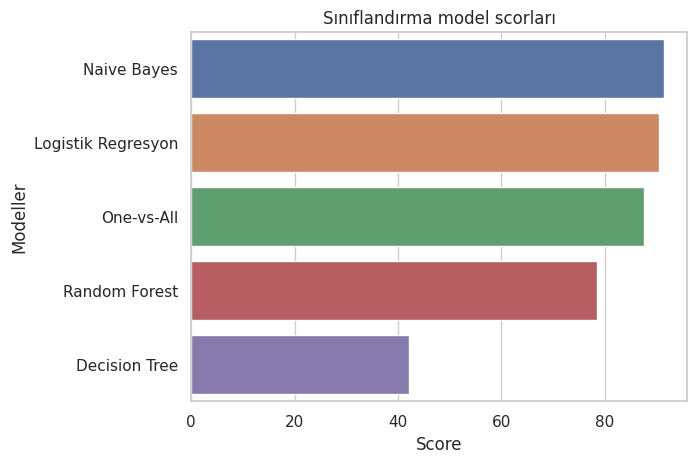

In [38]:
sns.barplot( x= model_sort.Score , y=model_sort.Model )

plt.xlabel("Score")
plt.ylabel("Modeller")
plt.title("Sınıflandırma model scorları")
plt.show()

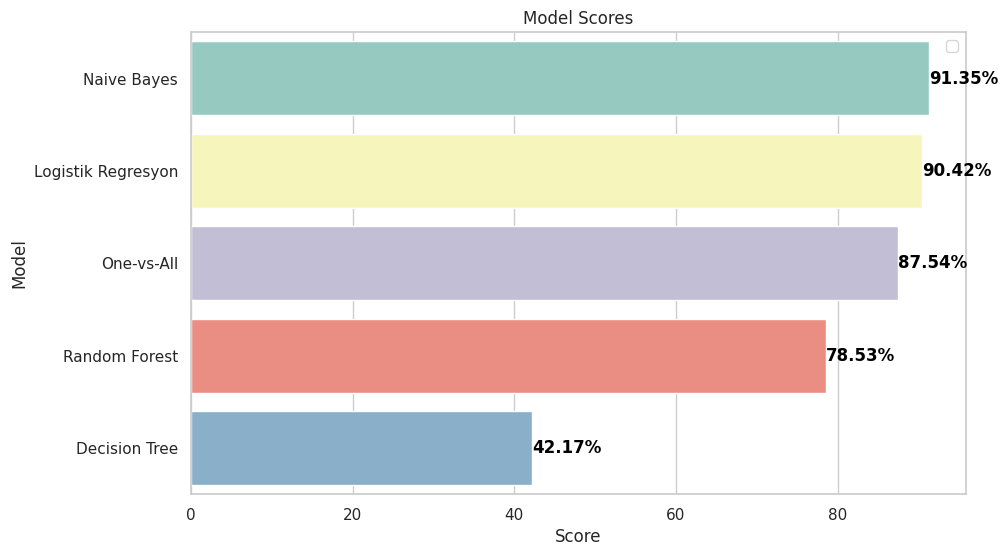

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set a different color palette
custom_colors = sns.color_palette("Set3", len(model_sort.Model))

# Set the style for the plot
sns.set(style="whitegrid")

# Create a bar plot
plt.figure(figsize=(10, 6))
bar_plot = sns.barplot(x=model_sort.Score, y=model_sort.Model, palette=custom_colors)

# Display the scores on the bars
for index, value in enumerate(model_sort.Score):
    bar_plot.text(value, index, f'{value:.2f}%', ha="left", va="center", color='black', fontweight='bold')

# Customize the plot
plt.xlabel('Başarı Yüzdesi')
plt.ylabel('Model')
plt.title('Model Başarı Skorları')


# Add legend
plt.legend()

# Show the plot
plt.show()